In [1]:
import os
import pickle

from jasyntho import SynthTree
from jasyntho.extract import ExtractReaction


async def extract_tree(
    path, model="gpt-3.5-turbo", method="text", si_select=False
):
    tree = SynthTree.from_dir(path)
    tree.rxn_extract = ExtractReaction(llm=model)

    tree.raw_prods = await tree.async_extract_rss(
        mode=method, si_select=si_select
    )
    tree.products = [p for p in tree.raw_prods if not p.isempty()]

    reach_sgs = tree.partition()
    return tree

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load ground truth graph
import networkx as nx

path = "../benchmark/papers/ja074300t"
with open(os.path.join(path, "gt_graph.pickle"), "rb") as f:
    gt_G = pickle.load(f)

In [3]:
# Extract a graph from paper

# tree = await extract_tree(path, model='gpt-3.5-turbo', method='vision')
# extracted_G = tree.full_g

# with open(os.path.join(path, 'extracted_graph_gpt35_vision.pickle'), 'wb') as f:
#     pickle.dump(extracted_G, f)

with open(
    os.path.join(path, "extracted_graph_gpt35_vision.pickle"), "rb"
) as f:
    extracted_G = pickle.load(f)

# Ways of comparing the two graphs

- Graph Edit Distance  # very slow
- Subgraph matching
- Spectral analysis
- Edge overlap

In [4]:
# sorts of subgraph matching


# Find subgraphs of extracted graph, and compare with ground truth graph
def find_subgraphs_larger_than_n(G, N):
    subgraphs = []

    # Find all connected components (subgraphs) in the graph
    connected_subgraphs = nx.connected_components(G)

    # Iterate over each connected subgraph
    for subgraph_nodes in connected_subgraphs:

        # Check if the size of the subgraph is greater than N
        if len(subgraph_nodes) > N:
            # Create a subgraph from the nodes
            subgraph = G.subgraph(subgraph_nodes)
            subgraphs.append(subgraph)

    return subgraphs


# Find subgraphs of size greater than 3
N = 3
subg_3 = find_subgraphs_larger_than_n(extracted_G.to_undirected(), N)


def subgraph_in_gt(subgraph, gt_G):
    # Check if the subgraph is present in the host graph
    matcher = nx.algorithms.isomorphism.GraphMatcher(gt_G, subgraph)
    is_match = matcher.subgraph_is_isomorphic()

    if is_match:
        print("The subgraph is present in the host graph.")
        # Get the mapping of nodes between the subgraph and the host graph
        mapping = matcher.mapping
        print("Mapping:", mapping)
    else:
        print("The subgraph is not present in the host graph.")


# for subgraph in subg_3:
#     subgraph_in_gt(subgraph, gt_G.to_undirected())

In [5]:
# Compare the immediate neighborhood of the nodes. e.g. is the local structure preserved?


def get_neighborhood_subgraph(G, node):
    # Get the incoming and outgoing neighbors of the node
    in_neighbors = [edge[0] for edge in G.in_edges(node)]
    out_neighbors = [edge[1] for edge in G.out_edges(node)]
    neighbors = set(in_neighbors + out_neighbors + [node])
    subgraph = G.subgraph(neighbors)
    return subgraph


def subgraph_in_gt_exact(subgraph, gt_G):
    """Check if the subgraph is present in the host graph."""
    subg_gt = gt_G.subgraph(subgraph.nodes)
    if len(subg_gt) == len(subgraph):
        return True
    return False


def subgraph_in_gt_isomorphic(subgraph, gt_G):
    matcher = nx.algorithms.isomorphism.GraphMatcher(gt_G, subgraph)
    is_match = matcher.subgraph_is_isomorphic()
    return is_match


def compare_local_exact_0(G, gt_G):
    quant = []
    for node in G.nodes:
        sg = get_neighborhood_subgraph(G, node)
        if len(sg) > 1:
            v = subgraph_in_gt_exact(sg, gt_G)
            quant.append(v)
    return (sum(quant) + 1) / (len(quant) + 1)


def compare_local_exact(gt_G, G):
    c1 = compare_local_exact_0(gt_G, G)
    c2 = compare_local_exact_0(G, gt_G)
    return c1, c2


def compare_local_iso(G, gt_G):
    quant = []
    for node in G.nodes:
        sg = get_neighborhood_subgraph(G, node)
        if len(sg) > 1:
            v = subgraph_in_gt_isomorphic(sg, gt_G)
            quant.append(v)
    return (sum(quant) + 1) / (len(quant) + 1)

In [6]:
print(compare_local_exact(gt_G, gt_G))
print(compare_local_exact(gt_G, extracted_G))

# Compare with other syntheses
path2 = "../benchmark/papers/jacs.0c00308"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_local_exact(other_G, gt_G))
path2 = "../benchmark/papers/jacs.0c00363"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_local_exact(other_G, gt_G))

(1.0, 1.0)
(0.05154639175257732, 0.2191780821917808)
(0.015625, 0.005154639175257732)
(0.023529411764705882, 0.010309278350515464)


In [7]:
# Similar thing, but with paths (testing more long-range structure)


def get_paths(G):
    paths = []
    for n0 in G.nodes:
        for n1 in G.nodes:
            if n0 != n1:
                if nx.has_path(G, n0, n1):
                    ps = nx.all_simple_paths(G, source=n0, target=n1)
                    paths += list(ps)
    return paths


def compare_path_exact_0(G, gt_G):
    """How many paths in G are also in gt_G"""
    quant = []
    subgraphs = get_paths(G)
    for path in subgraphs:
        if len(path) > 1:
            sg = G.subgraph(path)
            v = subgraph_in_gt_exact(sg, gt_G)
            quant.append(v)
    return (sum(quant) + 1) / (len(quant) + 1)


def compare_path_exact(gt_G, G):
    # gt_G in G
    c0 = compare_path_exact_0(gt_G, G)
    # G in gt_G
    c1 = compare_path_exact_0(G, gt_G)
    return c0, c1


print(compare_path_exact(gt_G, gt_G))
print(compare_path_exact(gt_G, extracted_G))

# Compare with other syntheses
path2 = "../benchmark/papers/jacs.0c00308"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact(gt_G, other_G))
path2 = "../benchmark/papers/jacs.0c00363"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact(gt_G, other_G))

(1.0, 1.0)
(0.10898543569489015, 0.313458262350937)
(0.00012342631449024932, 0.0005257623554153522)
(0.0004937052579609973, 0.0040137614678899085)


In [83]:
# Similar thing, but with pruned trees paths (test only backbone)


def get_paths(G):
    paths = []
    for n0 in G.nodes:
        for n1 in G.nodes:
            if n0 != n1:
                if nx.has_path(G, n0, n1):
                    ps = nx.all_simple_paths(G, source=n0, target=n1)
                    paths += list(ps)
    return paths


def prune(G):
    """Drop all nodes with outdeg==0."""
    pruned = G.copy()
    for node in G.nodes:
        if G.out_degree(node) == 0:
            pruned.remove_node(node)
    return pruned


def compare_path_exact_0(G, gt_G):
    """How many paths in pruned-G are also in pruned-gt_G"""
    quant = []
    subgraphs = get_paths(G)
    for path in subgraphs:
        if len(path) > 1:
            sg = G.subgraph(path)
            v = subgraph_in_gt_exact(sg, gt_G)
            quant.append(v)

    return (sum(quant) + 1) / (len(quant) + 1)


def compare_path_exact_pruned(gt_G, G):
    pG = prune(G)
    pgt_G = prune(gt_G)

    # gt_G in G
    c0 = compare_path_exact_0(pgt_G, pG)
    # G in gt_G
    c1 = compare_path_exact_0(pG, pgt_G)
    return c0, c1


print(compare_path_exact_pruned(gt_G, gt_G))
print(compare_path_exact_pruned(gt_G, extracted_G))

# Compare with other syntheses
path2 = "../benchmark/papers/jacs.0c00308"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact_pruned(gt_G, other_G))
path2 = "../benchmark/papers/jacs.0c00363"
with open(os.path.join(path2, "gt_graph.pickle"), "rb") as f:
    other_G = pickle.load(f)
    print(compare_path_exact_pruned(gt_G, other_G))

(1.0, 1.0)
(0.05918141592920354, 0.4689655172413793)
(0.0005530973451327434, 0.001160092807424594)
(0.0011061946902654867, 0.010723860589812333)


In [28]:
# TODO next: compare routes extracted with different methods! see if they make sense


async def extractg(
    path, model="gpt-3.5-turbo", method="text", si_select=False
):

    tree = await extract_tree(
        path, model=model, method=method, si_select=si_select
    )
    extracted_G = tree.full_g

    if model == "gpt-3.5-turbo":
        k = "gpt35"
    elif model == "gpt-4-turbo":
        k = "gpt4t"
    elif model == "gpt-4":
        k = "gpt4"
    elif model == "gpt-4o":
        k = "gpt4o"

    if si_select:
        si = "select"
    else:
        si = ""

    with open(
        os.path.join(path, f"extracted_graph_{k}_{method}_{si}.pickle"), "wb"
    ) as f:
        pickle.dump(extracted_G, f)

    return extracted_G

In [29]:
# eg = await extractg(path, model="gpt-3.5-turbo", method="text", si_select=True)
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(path, model="gpt-4-turbo", method="text", si_select=True)
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(
#     path, model="gpt-3.5-turbo", method="vision", si_select=True
# )
# print(compare_path_exact(eg, gt_G))

# eg = await extractg(path, model="gpt-4-turbo", method="vision", si_select=True)
# print(compare_path_exact(eg, gt_G))

In [40]:
for method in ["text", "vision"]:
    for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
        for si_select in [True, False]:

            if model == "gpt-3.5-turbo":
                k = "gpt35"
            elif model == "gpt-4-turbo":
                k = "gpt4t"
            elif model == "gpt-4":
                k = "gpt4"
            elif model == "gpt-4o":
                k = "gpt4o"

            if si_select:
                si = "_select"
            else:
                si = ""
            with open(
                os.path.join(path, f"extracted_graph_{k}_{method}{si}.pickle"),
                "rb",
            ) as f:
                og = pickle.load(f)
                print(k, method, si)
                print("Path:", compare_path_exact(gt_G, og))
                print("Local:", compare_local_exact(gt_G, og))
                print("PLocl:", compare_path_exact_pruned(gt_G, og))

gpt35 text _select
Path: (0.00024685262898049864, 0.02197802197802198)
Local: (0.010309278350515464, 0.03333333333333333)
PLocl: (0.0005530973451327434, 0.1111111111111111)


FileNotFoundError: [Errno 2] No such file or directory: '../benchmark/papers/jacs.0c02143/extracted_graph_gpt35_text.pickle'

In [82]:
# For all directories in benchmark, load the graphs with each method and compare with ground truth
import os
import pickle


def load_gr_graph(path, model="gpt-3.5-turbo", method="text", si_select=False):
    if model == "gpt-3.5-turbo":
        k = "gpt35"
    elif model == "gpt-4-turbo":
        k = "gpt4t"
    elif model == "gpt-4":
        k = "gpt4"
    elif model == "gpt-4o":
        k = "gpt4o"

    if si_select:
        si = "select"
    else:
        si = ""

    with open(
        os.path.join(path, f"extracted_graph_{k}_{method}_{si}.pickle"),
        "rb",
    ) as f:
        exg = pickle.load(f)
    return exg


import pandas as pd

discarded = ["jacs.3c07019", "jacs.3c01991", "jacs.8b06755", "jacs.7b11299"]
df = []

for paper in os.listdir("../benchmark/papers"):
    print(paper)
    if paper in discarded:
        continue
    path = os.path.join("../benchmark/papers", paper)
    if "gt_graph.pickle" in os.listdir(path):
        with open(os.path.join(path, "gt_graph.pickle"), "rb") as f:
            gt = pickle.load(f)
    else:
        continue
        with open(
            os.path.join(path, "extracted_graph_gpt4t_vision_.pickle"), "rb"
        ) as f:
            gt = pickle.load(f)

    for method in ["vision", "text"]:
        for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
            for si_select in [True, False]:
                try:
                    og = load_gr_graph(path, model, method, si_select)
                except:
                    continue

                loc = compare_porder(gt, og)
                pat = compare_path_exact(gt, og)
                prun = compare_path_exact_pruned(gt, og)
                df.append(
                    {
                        "paper": paper,
                        "model": model,
                        "method": method,
                        "si_select": si_select,
                        "path_sim_in": pat[0],
                        "path_sim_out": pat[1],
                        "local_sim_in": loc[0],
                        "local_sim_out": loc[1],
                        "ploc_sim_in": prun[0],
                        "ploc_sim_out": prun[1],
                    }
                )


df = pd.DataFrame(df)

# 3c07019
df

jacs.2c06934
lasdla 1222
lasdla 1515
lasdla 1017
lasdla 487
lasdla 1222
lasdla 495
lasdla 1017
lasdla 113
lasdla 1222
lasdla 404
lasdla 1017
lasdla 76
lasdla 1222
lasdla 560
lasdla 1017
lasdla 91
lasdla 1222
lasdla 53
lasdla 1017
lasdla 6
lasdla 1222
lasdla 657
lasdla 1017
lasdla 168
lasdla 1222
lasdla 3583
lasdla 1017
lasdla 980
jacs.9b09699
jacs.7b11299
jacs.7b07724
lasdla 433
lasdla 119
lasdla 259
lasdla 32
lasdla 433
lasdla 319
lasdla 259
lasdla 81
lasdla 433
lasdla 73
lasdla 259
lasdla 9
lasdla 433
lasdla 205
lasdla 259
lasdla 32
lasdla 433
lasdla 173
lasdla 259
lasdla 26
lasdla 433
lasdla 157
lasdla 259
lasdla 20
lasdla 433
lasdla 1607
lasdla 259
lasdla 240
lasdla 433
lasdla 1340
lasdla 259
lasdla 209
jacs.7b00807
lasdla 4074
lasdla 511
lasdla 1066
lasdla 158
lasdla 4074
lasdla 542
lasdla 1066
lasdla 249
lasdla 4074
lasdla 613
lasdla 1066
lasdla 189
lasdla 4074
lasdla 828
lasdla 1066
lasdla 391
lasdla 4074
lasdla 480
lasdla 1066
lasdla 86
lasdla 4074
lasdla 507
lasdla 1066
lasdla

,paper,model,method,si_select,path_sim_in,path_sim_out,local_sim_in,local_sim_out,ploc_sim_in,ploc_sim_out
0,jacs.2c06934,gpt-3.5-turbo,vision,True,0.111202,0.094987,0.237893,0.434524,0.129666,0.286885
1,jacs.2c06934,gpt-3.5-turbo,vision,False,0.145544,0.062500,0.028887,0.861004,0.037328,0.166667
2,jacs.2c06934,gpt-4-turbo,vision,True,0.044971,0.069136,0.124894,0.884615,0.027505,0.194805
3,jacs.2c06934,gpt-4-turbo,vision,False,0.122649,0.076649,0.063721,0.564815,0.044204,0.391304
4,jacs.2c06934,gpt-3.5-turbo,text,True,0.001635,0.037037,0.581138,1.000000,0.001965,0.285714
...,...,...,...,...,...,...,...,...,...,...
176,jacs.0c02143,gpt-4-turbo,vision,True,0.728643,0.423889,0.499456,0.412522,0.925373,0.671371
177,jacs.0c02143,gpt-4-turbo,vision,False,0.625126,0.711340,0.319913,0.746377,0.283582,0.855932
178,jacs.0c02143,gpt-3.5-turbo,text,True,0.367839,0.428571,0.033732,0.352941,0.011194,0.555556
179,jacs.0c02143,gpt-4-turbo,text,True,0.666332,0.594030,0.298150,0.562290,0.753731,0.778894


In [85]:
df[(df["model"] == "gpt-4-turbo") & (df["method"] == "text")].groupby("paper")[
    ["local_sim_in", "local_sim_out", "ploc_sim_in", "ploc_sim_out"]
].mean().sort_values("ploc_sim_in", ascending=False)

,local_sim_in,local_sim_out,ploc_sim_in,ploc_sim_out
paper,,,,
jacs.8b03015,0.721122,1.000000,1.000000,0.883978
jacs.8b13029,1.000000,1.000000,0.994048,1.000000
jacs.0c02143,0.422198,0.524349,0.800373,0.841990
jacs.0c00308,0.496000,0.559401,0.725058,0.693993
jacs.7b09929,0.871313,0.503575,0.661483,0.925468
jacs.6b07846,0.468531,0.505607,0.613971,0.846074
jacs.7b07724,0.151134,0.173944,0.534615,0.820006
jacs.9b12546,0.078272,0.872399,0.428763,0.926829
jacs.9b05013,0.392505,0.646149,0.380857,0.794409


In [86]:
# Average score across papers

_vars = [
    "path_sim_in",
    "path_sim_out",
    "local_sim_in",
    "local_sim_out",
    "ploc_sim_in",
    "ploc_sim_out",
]
df.groupby(["model", "method", "si_select"])[_vars].mean()

path_sim_in  path_sim_out  local_sim_in  \
model         method si_select                                            
gpt-3.5-turbo text   False         0.198100      0.473934      0.199557   
                     True          0.132148      0.426006      0.240191   
              vision False         0.334440      0.318848      0.174548   
                     True          0.285645      0.407437      0.274830   
gpt-4-turbo   text   False         0.503068      0.578689      0.474695   
                     True          0.410808      0.565010      0.453439   
              vision False         0.421602      0.407426      0.214803   
                     True          0.267177      0.439528      0.339876   

                                local_sim_out  ploc_sim_in  ploc_sim_out  
model         method si_select                                            
gpt-3.5-turbo text   False           0.673063     0.034700      0.686189  
                     True            0.767772     0.026339      0.685155  
              vision False           0.555899     0.195880      0.436533  
                     True            0.601977     0.243655      0.627531  
gpt-4-turbo   text   False           0.562310     0.391852      0.751504  
                     True            0.651279     0.339467      0.740316  
              vision False           0.641154     0.279360      0.658675  
                     True            0.600665     0.237719      0.653160

In [136]:
# Visualize the results for all methods

import matplotlib.pyplot as plt
import seaborn as sns

# Create the hierarchical boxplot with custom figure size


def make_plot(metric):
    df_ = df.sort_values(by=["method", "model"])

    plt.rcParams["font.size"] = 14

    g = sns.catplot(
        x="model",
        y=metric,
        hue="si_select",
        col="method",
        data=df_,
        height=5,
        aspect=0.5,
        size=7,
        alpha=0.8,
        palette="magma",
        # legend=False
    )

    axes = g.axes.flatten()
    means = df.groupby(["model", "method", "si_select"])[metric].mean()
    w = 0.41

    for method in ["text", "vision"]:
        for model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
            for si_select in [True, False]:
                if method == "text":
                    ax = axes[0]
                else:
                    ax = axes[1]

                if model == "gpt-3.5-turbo":
                    x = [0 - w, 0 + w]
                else:
                    x = [1 - w, 1 + w]

                if si_select:
                    color = "#F15F5C"
                else:
                    color = "#721F81"

                mean = means.loc[(model, method, si_select)]
                ax.plot(
                    x,
                    [mean, mean],
                    marker="",
                    linestyle="--",
                    color=color,
                    linewidth=2,
                )
                ax.set_ylabel("")
                ax.set_xlabel("")
                ax.set_xticklabels([])
                ax.set_title("")
    print(metric)
    plt.show()

    plt.savefig(f"{metric}.svg")

    # Display mean for each method
    #
    # mean

    # plt.savefig('path_sim_in.svg')

local_sim_in


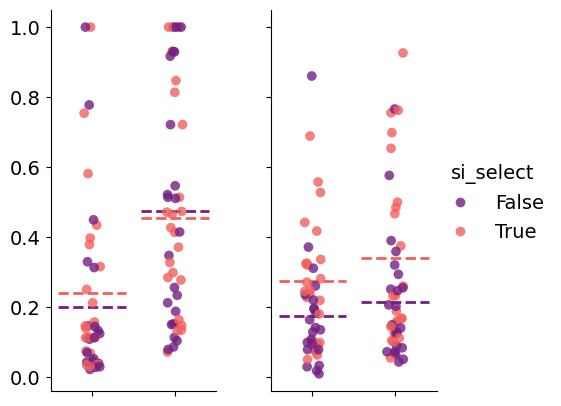

local_sim_out


<Figure size 640x480 with 0 Axes>

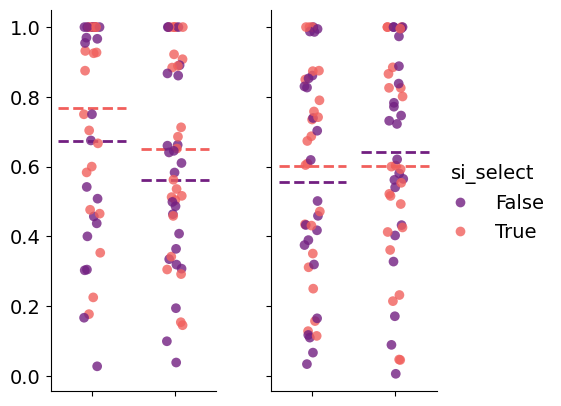

path_sim_in


<Figure size 640x480 with 0 Axes>

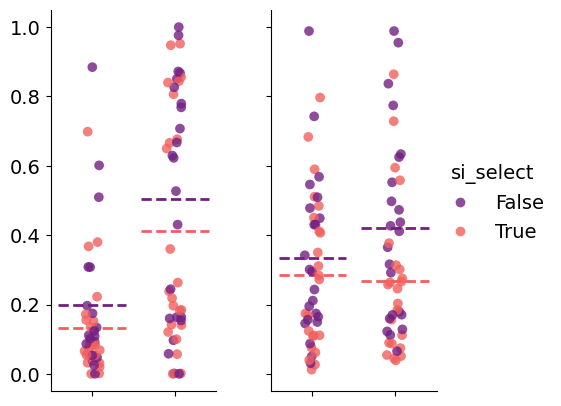

path_sim_out


<Figure size 640x480 with 0 Axes>

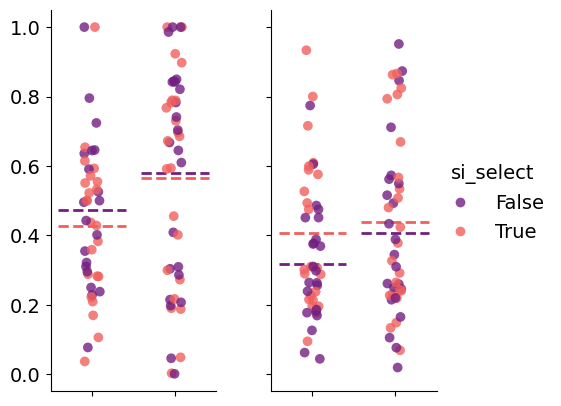

ploc_sim_in


<Figure size 640x480 with 0 Axes>

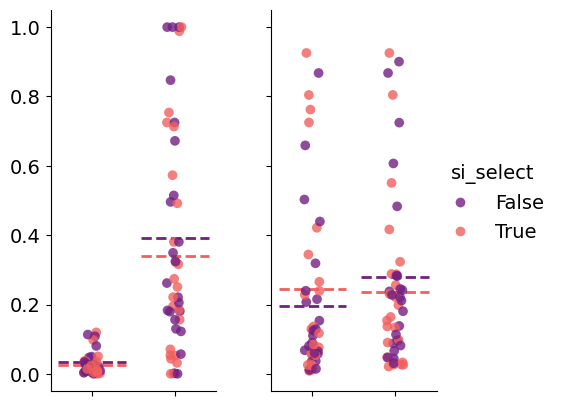

ploc_sim_out


<Figure size 640x480 with 0 Axes>

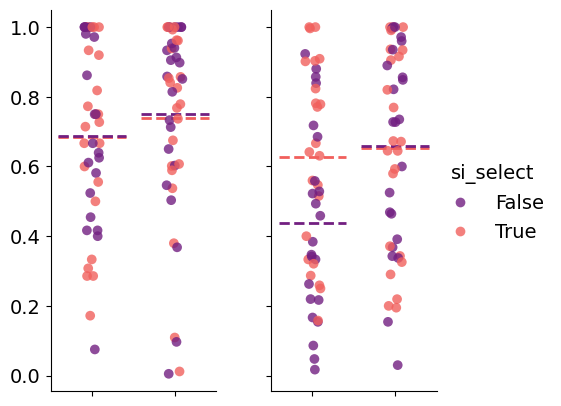

<Figure size 640x480 with 0 Axes>

In [137]:
for m in [
    "local_sim_in",
    "local_sim_out",
    "path_sim_in",
    "path_sim_out",
    "ploc_sim_in",
    "ploc_sim_out",
]:
    make_plot(m)

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def extract_subgraph(graph, start_node):
    """Use BFS to find all nodes reachable from start_node."""
    reachable_nodes = set(nx.bfs_tree(graph, start_node))
    return graph.subgraph(reachable_nodes).copy()


def plot_graph(G):
    fig = plt.figure(figsize=(10, 7))
    pos = graphviz_layout(G, prog="dot")
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.show()


reach_sgs = SynthTree.get_reach_subgraphs(extracted_G)
print(len(reach_sgs))

# for g in reach_sgs.values():
#     if len(g) > 1:
#             plot_graph(g)
#             print(g.nodes)

68


In [81]:
from pydantic import BaseModel


class POSet(BaseModel):
    path: nx.DiGraph

    class Config:
        arbitrary_types_allowed = True

    def gt(self, a, b):
        """Check if a is greater than b."""
        return nx.has_path(self.path, a, b)

    def iso(self, _poset):
        """Check if this poset contains _poset."""
        # If nodes in _poset not contained in self
        if set(self.path.nodes).intersection(_poset.path.nodes) != set(
            _poset.path.nodes
        ):
            return False

        # Else, check that the gt relation is preserved for each edge in _poset
        for i in _poset.path.nodes:
            for j in _poset.path.nodes:
                if i != j:
                    if not self.gt(i, j) == _poset.gt(i, j):
                        return False
        return True


def compare_path_exact_pruned(gt_G, G):
    pG = prune(G)
    pgt_G = prune(gt_G)

    # gt_G in G
    c0 = compare_path_exact_0(pgt_G, pG)
    # G in gt_G
    c1 = compare_path_exact_0(pG, pgt_G)
    return c0, c1


def compare_porder_0(G, gt_G):
    quant = []
    subgraphs = get_paths(G)
    for path in subgraphs:
        if len(path) > 2:
            sg = POSet(path=G.subgraph(path))
            gt_sg = POSet(path=gt_G.subgraph(path))
            quant.append(sg.iso(gt_sg))

    return (sum(quant) + 1) / (len(quant) + 1)


def compare_porder(gt_G, G):
    c0 = compare_porder_0(gt_G, G)
    c1 = compare_porder_0(G, gt_G)
    return c0, c1

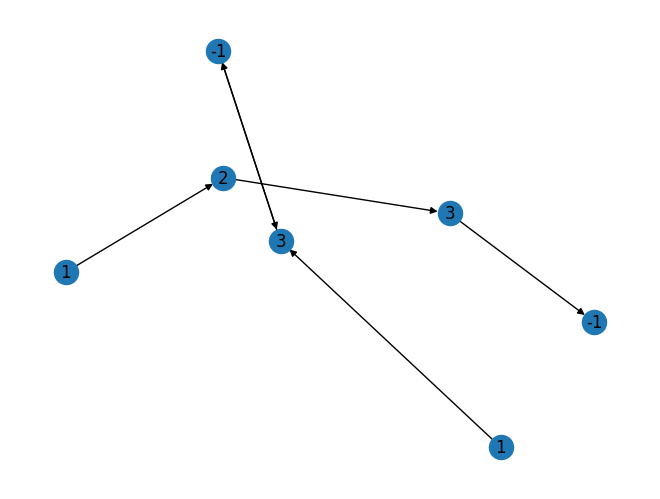

In [70]:
nx.draw(gg, with_labels=True)
nx.draw(gg2, with_labels=True)

In [140]:
# load all the gt_graphs in each directory, and calculate some stats

import os
import pickle


def load_gt_graph(path):
    try:
        with open(os.path.join(path, "gt_graph.pickle"), "rb") as f:
            gt = pickle.load(f)
            return gt
    except:
        return None


grs = []
for paper in os.listdir("../benchmark/papers"):
    path = os.path.join("../benchmark/papers", paper)
    gt = load_gt_graph(path)
    if gt is not None:
        grs.append(gt)


# Calculate total number of nodes with outdegree != 0
def prune(G):
    """Drop all nodes with outdeg==0."""
    pruned = G.copy()
    for node in G.nodes:
        if G.out_degree(node) == 0:
            pruned.remove_node(node)
    return pruned


def get_pruned_nodes(G):
    pruned = prune(G)
    return len(pruned.nodes)


nnods = [get_pruned_nodes(g) for g in grs]
import numpy as np

np.mean(nnods)

45.26086956521739

In [141]:
sum(nnods)

1041

In [142]:
def get_n_heads(G):
    return len([n for n in G.nodes if G.in_degree(n) == 0])


nheads = [get_n_heads(g) for g in grs]
np.mean(nheads)

8.869565217391305

In [157]:
# Longest path
import networkx as nx


def find_longest_path(G):
    longest_path = []

    for source in G.nodes():
        for target in G.nodes():
            if source != target:
                for path in nx.all_simple_paths(
                    G, source=source, target=target
                ):
                    if len(path) > len(longest_path):
                        longest_path = path

    return len(longest_path)


np.mean()

19.652173913043477

In [159]:
max([find_longest_path(i) for i in grs])

33